In [1]:
%matplotlib inline
%load_ext autoreload

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

import sncosmo

from copy import deepcopy
import gedankenLSST

from LSSTmetrics import PerSNMetric
from lsst.sims.photUtils import BandpassDict

import analyzelcFits as anf

In [2]:
# Run this once. It does not change

lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    #print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

In [3]:
lsstCadence = deepcopy(gedankenLSST.LSSTReq)

In [4]:
# function that produces expected value of variances for many shifted lightcurves
# sncosmo_lc


def shift_loop(delta_t0, lsst_obs):
    var = []

    for i in delta_t0:
        try:
            sn = PerSNMetric(summarydf=lsst_obs.summary,t0=i, raCol='ra', decCol='dec', lsst_bp=lsst_bp)
            var.append(1.0/sn.qualityMetric(Disp=1.0))
            #print 'variance!', var[i]
        except:
            print('I failed!')
    
    return np.mean(np.array(var))


In [5]:
def shift_loop_mcmc(delta_t0, lsst_obs):
    model = sncosmo.Model(source='salt2-extended')
    var = []

    for i in delta_t0:
        try:
            sn = PerSNMetric(summarydf=lsst_obs.summary,t0=i, raCol='ra', decCol='dec', lsst_bp=lsst_bp)
            data = sn.SNCosmoLC() 
            mcmc_out = sncosmo.mcmc_lc(data,model,['z', 't0', 'x0', 'x1', 'c'],bounds={'z':(0.3, 0.7)})
            t = anf.ResChar.fromSNCosmoRes(mcmc_out)
            print i,t.salt_samples().mu.std()
            var.append(t.salt_samples().mu.std()*t.salt_samples().mu.std())
        except:
            print('I failed!')
    
    return np.mean(np.array(var))

In [6]:
# use LSST cadence
# choose number of lightcurves to shift
# for each shifted lightcurve, evaluate at sampling locations (no measurement errors for now)
# for each shifted lightcurve, calculate variance of parameters, then sum them to get expected value of variance
# profit



def cadence_loop(bumps,delta_t0):
    #delta_t0 = np.linspace(snLSST.SN.mintime(), snLSST.SN.maxtime(), 10)
    #print delta_t0
    #print bumps
    length = []
    mu_variance_per_bump = []
    for i in bumps:
        print i
        lsstCadence['bF'] = i
        
        lsst_obs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=lsstCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-130., 150.]) 
        length.append(len(lsst_obs.summary))
        mu_variance_per_bump.append(shift_loop(delta_t0, lsst_obs))
    
    return mu_variance_per_bump, length

def cadence_loop_mcmc(bumps,delta_t0):
    ## Could move this function into the previous function and have mcmc be an option.
    length = []
    mu_variance_per_bump = []
    for i in bumps:
        print i
        lsstCadence['bF'] = i
        
        lsst_obs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=lsstCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-130., 150.]) 
        length.append(len(lsst_obs.summary))
        mu_variance_per_bump.append(shift_loop_mcmc(delta_t0, lsst_obs)) ### This line is the only difference between the two.
    
    return mu_variance_per_bump, length



In [6]:
t0 = 49570.
dt = 50.
delta_t0 = np.linspace(t0-dt,t0+dt,10)
#49540.0
#49645.0

#normalize Max-Min/ time window

bumps = np.arange(0.1, 3, 0.2)
mvpb, length = cadence_loop(bumps,delta_t0)

0.1
0
I failed!
5
5
5
5
5
5
5
5

/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']
/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['DetectionEfficiency'] = df.apply(self.func, axis=1)
/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d


0
I failed!
0.3
9
6
6
6
9
9
6
6
6
9
0.5
10
13
10
10
9
9
10
I failed!
10
13
10
0.7
17
15
14
14
15
15
14
14
15
17
0.9
18
19
17
17
18
18
19
17
19
18
1.1
19
23
24
20
21
21
20
24
23
19
1.3
23
25
26
25
24
24
25
I failed!
26
25
23
1.5
29
29
29
29
27
I failed!
27
29
29
I failed!
29
29
1.7
34
34
31
31
31
31
31
31
34
34
1.9
35
37
36
37
34
34
35
36
37
35
I failed!
2.1
41
41
41
39
39
39
39
41
I failed!
41
41
2.3
44
41
42
43
43
43
43
42
41
44
2.5
46
51
45
46
45
45
49
45
51
46
2.7
51
52
51
49
51

/Users/karaponder/anaconda/lib/python2.7/site-packages/sncosmo-1.1.dev516-py2.7-macosx-10.5-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.500000
         t0 = +49600.316447
         x0 = +0.000034
         x1 = -7.602468
          c = -116.111286
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.053107
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)
/Users/karaponder/anaconda/lib/python2.7/site-packages/sncosmo-1.1.dev516-py2.7-macosx-10.5-x86_64.egg/sncosmo/fitting.py:428: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
          z = +0.500000
         t0 = +49470.688425
         x0 = +0.211796
         x1 = -47.939012
          c = +1053.448500
    hostebv = +0.000000
    hostr_v = +3.100000
      mwebv = +0.053107
      mwr_v = +3.100000

  d, l = m.migrad(ncall=maxcall)



I failed!
51
49
51
52
I failed!
51
2.9
55
53
56
54
55
55
54
56
53
55


In [7]:
#bumps1 = np.arange(0.2, 1.5, 0.2)
#mvpb1, length1 = cadence_loop(bumps1,delta_t0)
t0 = 49570.
dt = 50.
delta_t0 = np.linspace(t0-dt,t0+dt,10)

bumps1 = np.arange(1.0, 2.0, 0.5)
mvpb1, length1 = cadence_loop_mcmc(bumps1,delta_t0)

1.0
20

/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']
/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['DetectionEfficiency'] = df.apply(self.func, axis=1)
/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d


49520.0 0.310162719982
19
49531.1111111 0.291300568824
21
49542.2222222 0.315577696881
19
49553.3333333 0.277353852686
20
49564.4444444 0.28068672604
20
49575.5555556 0.32226412806
19
49586.6666667 0.327839980248
21
49597.7777778 0.389105087319
19
49608.8888889 0.242226332359
20
49620.0 0.290435158445
1.5
29
49520.0 0.191278735597
29
49531.1111111 0.245515690749
29
49542.2222222 0.283541189089
29
49553.3333333 0.343361647114
27
49564.4444444 0.23249573874
27
49575.5555556 0.221241327103
29
49586.6666667 0.239539163002
29
49597.7777778 0.251706611179
29
49608.8888889 0.215159293263
29
49620.0 0.22207789387


/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['modelFlux'] = lc['flux']
/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['deviation'] = np.random.normal(size=len(lc['flux']))


(-1, 2)

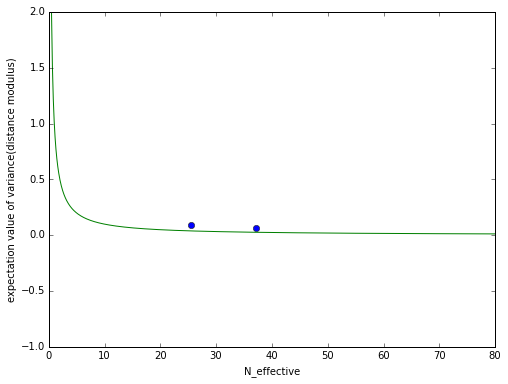

In [8]:
normalize =(49645.0 - 49540.0)/(130.+ 150.)

x = np.linspace(0.1, 80, 1000)

plt.figure(figsize = (8,6))
plt.plot(np.array(length1)*normalize, mvpb1, 'o')
plt.plot(x, 1.0/x, label = '1/N_eff')
plt.ylabel('expectation value of variance(distance modulus)')
plt.xlabel('N_effective')
plt.ylim(-1, 2)
#plt.savefig('preliminary_bump01_3.pdf')

## TESTING BELOW

In [7]:
## THIS IS WHAT YOU NEED TO CHANGE
lsstCadence['bF'] = 1


# time window increased to 200 days to make sure LC stays within time frame
lsst_obs = gedankenLSST.GSN_Obs(mjd_center=49570., 
                                    lsstrequirements=lsstCadence,
                                    ra=58., dec=-27.,
                                    timeWindow=[-130., 150.]) 


In [8]:
snLSST = PerSNMetric(summarydf=lsst_obs.summary,t0=49570., raCol='ra', decCol='dec', lsst_bp=lsst_bp)

In [16]:
#1.0/ snLSST.qualityMetric(Disp=1.0) #= 0.05**2/sigma**2

[11, 43, 78, 109, 140, 171, 202, 233, 265, 296, 329, 360, 391, 423, 457, 486, 517, 550, 581, 614]


var = []
delta_t0 = np.linspace(snLSST.SN.mintime(), snLSST.SN.maxtime(), 10)

for i in delta_t0:
    try:
        sn = PerSNMetric(summarydf=lsst_obs.summary,t0=i, raCol='ra', decCol='dec', lsst_bp=lsst_bp)
        #sn.lcplot()
        #sn.SNCosmoLC()
        #print sn.qualityMetric(Disp=1.0)
        var.append(1.0/sn.qualityMetric(Disp=1.0))
    
        #print var
    except:
        print('I failed!')
    
mean_var = np.mean(np.array(var))

In [12]:
#print len(var), var, mean_var

print snLSST.SN.mintime()
print snLSST.SN.maxtime()

49540.0
49645.0


In [9]:
# function that takes a set of parameters, producing a lightcurve mathematical function
data = snLSST.SNCosmoLC() 


/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['modelFlux'] = lc['flux']
/Users/karaponder/.local/lib/python2.7/site-packages/LSSTmetrics/metrics.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['deviation'] = np.random.normal(size=len(lc['flux']))


20


In [12]:
## For plotting tests
# function that takes evaluates lightcurve function given a sampling strategy
#times = [54990., 55000., 55020.]
#samples = -1.*np.array(model.bandmag('desr', 'ab', times))
#plt.plot(times,samples)

In [15]:
# function that shifts lightcurve sampling, creating many samplings of same underlying lightcurve
#for x in times:
#    model.set(z=0.5, t0=x, amplitude=1.e-10)
#    sample = -1.*np.array(model.bandmag('desr', 'ab', times))
#    plt.plot(times,sample)
#plt.show()

In [10]:
# function that fits lightcurves to samples, producing some set of parameters and variances
# first try maximum likelihood method of sncosmo.fit_lc
#data = sncosmo.load_example_data()

model = sncosmo.Model(source='salt2-extended')

#mcmc_out = sncosmo.fit_lc(data,model,['z', 't0', 'x0', 'x1', 'c'],bounds={'z':(0.3, 0.7)})
#print(res.errors)

# next try sampling method of sncosmo.mcmc_lc
mcmc_out = sncosmo.mcmc_lc(data,model,['z', 't0', 'x0', 'x1', 'c'],bounds={'z':(0.3, 0.7)})
#print(res.errors)

In [11]:
t = anf.ResChar.fromSNCosmoRes(mcmc_out)
samples = t.salt_samples()
mu = samples['mu']

In [12]:
var_mu = t.salt_samples().mu.std()*t.salt_samples().mu.std()

In [ ]:
# function that calculates bias of fit parameters relative to true parameters

0.0570804918974
